In [47]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [48]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [49]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [50]:
import yfinance as yf

In [51]:
sp500 = yf.Ticker('^GSPC')

In [52]:
sp500 = sp500.history(period='max')

In [53]:
sp500

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,0.0,0.0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,0.0,0.0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,0.0,0.0
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,0.0,0.0
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,0.0,0.0
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,0.0,0.0


In [54]:
sp500.index

DatetimeIndex(['1927-12-30 00:00:00-05:00', '1928-01-03 00:00:00-05:00',
               '1928-01-04 00:00:00-05:00', '1928-01-05 00:00:00-05:00',
               '1928-01-06 00:00:00-05:00', '1928-01-09 00:00:00-05:00',
               '1928-01-10 00:00:00-05:00', '1928-01-11 00:00:00-05:00',
               '1928-01-12 00:00:00-05:00', '1928-01-13 00:00:00-05:00',
               ...
               '2023-11-29 00:00:00-05:00', '2023-11-30 00:00:00-05:00',
               '2023-12-01 00:00:00-05:00', '2023-12-04 00:00:00-05:00',
               '2023-12-05 00:00:00-05:00', '2023-12-06 00:00:00-05:00',
               '2023-12-07 00:00:00-05:00', '2023-12-08 00:00:00-05:00',
               '2023-12-11 00:00:00-05:00', '2023-12-12 00:00:00-05:00'],
              dtype='datetime64[ns, America/New_York]', name='Date', length=24103, freq=None)

In [55]:
import matplotlib.pyplot as mlt

<Axes: xlabel='Date'>

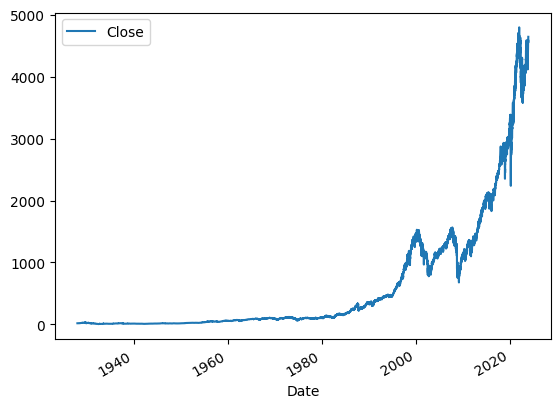

In [56]:
sp500.plot.line(y='Close',use_index=True)

In [57]:
del sp500['Dividends']

In [58]:
del sp500['Stock Splits']

In [59]:
sp500['Tommorow'] = sp500['Close'].shift(-1)

In [60]:
sp500

,Open,High,Low,Close,Volume,Tommorow
Date,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000
...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,4585.589844
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,4604.370117
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,4622.439941


In [61]:
sp500['Target'] = (sp500['Tommorow'] > sp500['Close']).astype(int)

In [62]:
sp500

,Open,High,Low,Close,Volume,Tommorow,Target
Date,,,,,,,
1927-12-30 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.760000,1
1928-01-03 00:00:00-05:00,17.760000,17.760000,17.760000,17.760000,0,17.719999,0
1928-01-04 00:00:00-05:00,17.719999,17.719999,17.719999,17.719999,0,17.549999,0
1928-01-05 00:00:00-05:00,17.549999,17.549999,17.549999,17.549999,0,17.660000,1
1928-01-06 00:00:00-05:00,17.660000,17.660000,17.660000,17.660000,0,17.500000,0
...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,4585.589844,1
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,4604.370117,1
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,4622.439941,1


In [63]:
sp500 = sp500.loc['1990-01-01':].copy()

In [64]:
sp500

,Open,High,Low,Close,Volume,Tommorow,Target
Date,,,,,,,
1990-01-02 00:00:00-05:00,353.399994,359.690002,351.980011,359.690002,162070000,358.760010,0
1990-01-03 00:00:00-05:00,359.690002,360.589996,357.890015,358.760010,192330000,355.670013,0
1990-01-04 00:00:00-05:00,358.760010,358.760010,352.890015,355.670013,177000000,352.200012,0
1990-01-05 00:00:00-05:00,355.670013,355.670013,351.350006,352.200012,158530000,353.790009,1
1990-01-08 00:00:00-05:00,352.200012,354.239990,350.540009,353.790009,140110000,349.619995,0
...,...,...,...,...,...,...,...
2023-12-06 00:00:00-05:00,4586.229980,4590.740234,4546.500000,4549.339844,4245680000,4585.589844,1
2023-12-07 00:00:00-05:00,4568.839844,4590.919922,4565.220215,4585.589844,3818880000,4604.370117,1
2023-12-08 00:00:00-05:00,4576.200195,4609.229980,4574.060059,4604.370117,3707010000,4622.439941,1


In [65]:
from sklearn.ensemble import RandomForestClassifier

In [66]:
model = RandomForestClassifier(n_estimators=100,min_samples_split=100,random_state=1)

In [67]:
train = sp500.iloc[:-100]

In [68]:
test = sp500.iloc[-100:]

In [69]:
predictors = ['Close', 'Volume', 'Open', 'High', 'Low']

In [70]:
model.fit(train[predictors],train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [71]:
from sklearn.metrics import precision_score

In [72]:
pred = model.predict(test[predictors])

In [73]:
import pandas as pd

In [74]:
pred = pd.Series(pred, index=test.index)

In [75]:
pred

Date
2023-07-24 00:00:00-04:00    1
2023-07-25 00:00:00-04:00    1
2023-07-26 00:00:00-04:00    1
2023-07-27 00:00:00-04:00    1
2023-07-28 00:00:00-04:00    1
                            ..
2023-12-06 00:00:00-05:00    1
2023-12-07 00:00:00-05:00    1
2023-12-08 00:00:00-05:00    1
2023-12-11 00:00:00-05:00    1
2023-12-12 00:00:00-05:00    1
Length: 100, dtype: int32

In [76]:
precision_score(test['Target'],pred)

0.48717948717948717

In [77]:
combined = pd.concat([test['Target'], pred], axis=1)

<Axes: xlabel='Date'>

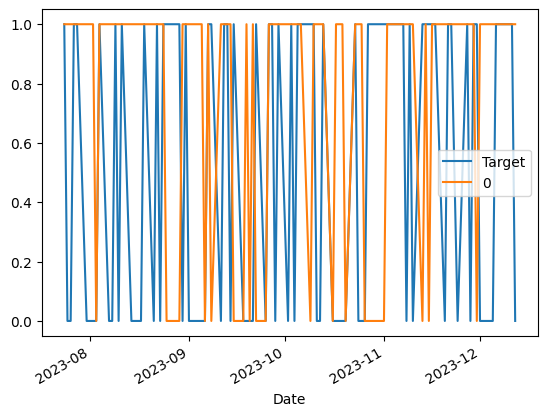

In [78]:
combined.plot()

In [79]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    pred = model.predict(test[predictors])
    pred = pd.Series(pred, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], pred], axis=1)
    return combined

In [80]:
def backtest(data, model, predictors, start=2500, step=250):
    all_pred=[]
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_pred.append(predictions)
    return pd.concat(all_pred)

In [ ]:
%prun predictions = backtest(sp500, model, predictors)

In [82]:
predictions['Predictions'].value_counts()

Predictions
0    3457
1    2596
Name: count, dtype: int64

In [83]:
predictions

,Target,Predictions
Date,,
1999-11-22 00:00:00-05:00,0,0
1999-11-23 00:00:00-05:00,1,0
1999-11-24 00:00:00-05:00,0,0
1999-11-26 00:00:00-05:00,0,0
1999-11-29 00:00:00-05:00,0,0
...,...,...
2023-12-06 00:00:00-05:00,1,0
2023-12-07 00:00:00-05:00,1,0
2023-12-08 00:00:00-05:00,1,1


In [84]:
precision_score(predictions['Target'],predictions['Predictions'])

0.5285053929121726

In [85]:
horizons = [2,5,60,1000]
new_predictors = []

In [86]:
for horizon in horizons:
    rolling_avg = sp500.rolling(horizon).mean()
    
    ratio_col = f"Close_ratio_{horizon}"
    sp500[ratio_col] = sp500['Close']/rolling_avg['Close']
    
    trend_col = f"Trend_{horizon}"
    sp500[trend_col] = sp500.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_col, trend_col]

In [87]:
sp500 = sp500.dropna()

In [88]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [89]:
def predict(train, test, predictors, model):
    model.fit(train[predictors],train['Target'])
    pred = model.predict_proba(test[predictors])[:,1]
    pred[pred>=.6] = 1
    pred[pred<.6] = 0
    pred = pd.Series(pred, index=test.index, name='Predictions')
    combined = pd.concat([test['Target'], pred], axis=1)
    return combined

In [90]:
%prun predictions = backtest(sp500, model, new_predictors)

         9015412 function calls (8898307 primitive calls) in 283.259 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
     4200  250.063    0.060  250.072    0.060 {method 'build' of 'sklearn.tree._tree.DepthFirstTreeBuilder' objects}
    12621    2.749    0.000    5.834    0.000 validation.py:1249(check_random_state)
     8421    2.377    0.000    2.377    0.000 {function SeedSequence.generate_state at 0x000001EF6C6BCEA0}
    21021    1.783    0.000    5.992    0.000 inspect.py:2368(_signature_from_function)
   273399    1.429    0.000    2.565    0.000 inspect.py:2729(__init__)
     4263    1.176    0.000    1.176    0.000 {method 'argsort' of 'numpy.ndarray' objects}
       57    1.055    0.019    1.055    0.019 {built-in method select.select}
     4242    1.051    0.000    1.051    0.000 {method 'sort' of 'numpy.ndarray' objects}
     8463    1.038    0.000    3.674    0.000 arraysetops.py:323(_unique1d)
     4200    0.9

In [91]:
predictions['Predictions'].value_counts()

Predictions
0.0    4249
1.0     803
Name: count, dtype: int64

In [92]:
precision_score(predictions["Target"],predictions['Predictions'])

0.5603985056039851